In [1]:
import pandas as pd
import numpy as np

from wordcloud import WordCloud

from typing import Callable

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords

import textstat
from razdel import tokenize

from tqdm.notebook import tqdm
tqdm.pandas()

from pandarallel import pandarallel
pandarallel.initialize(nb_workers=12, progress_bar=True)

from sklearn.model_selection import train_test_split

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [2]:
train = pd.read_csv('../../data/train_unique_reviews.csv')
test = pd.read_csv('../../data/test_unique_reviews.csv')

reviews = pd.concat([train, test], axis=0)
reviews

review  is_AI
0     Жаль, крем не оправдал ожиданий. Заявленный эф...      1
1     Платье красивое, но мне пришло с браком, очень...      0
2     Посылка пришла в непотребном виде.Получила на ...      0
3     Маленький принц’, 12+, оказался совсем не мале...      1
4     Адовая синтетика, но что за такую цену можно в...      0
...                                                 ...    ...
4685  Платье полностью не соответствует размеруXXL,к...      0
4686  Качество хорошее, свитер пушистый. Но размер н...      0
4687  Три месяца ждала заказ , так и не дождалась.\r...      0
4688                   Заказ не пришёл. Деньги вернули       0
4689  Отличные брюки. Тёмно-синий цвет подходит к мо...      1

[23446 rows x 2 columns]

In [3]:
reviews

review  is_AI
0     Жаль, крем не оправдал ожиданий. Заявленный эф...      1
1     Платье красивое, но мне пришло с браком, очень...      0
2     Посылка пришла в непотребном виде.Получила на ...      0
3     Маленький принц’, 12+, оказался совсем не мале...      1
4     Адовая синтетика, но что за такую цену можно в...      0
...                                                 ...    ...
4685  Платье полностью не соответствует размеруXXL,к...      0
4686  Качество хорошее, свитер пушистый. Но размер н...      0
4687  Три месяца ждала заказ , так и не дождалась.\r...      0
4688                   Заказ не пришёл. Деньги вернули       0
4689  Отличные брюки. Тёмно-синий цвет подходит к мо...      1

[23446 rows x 2 columns]

### WordCloud

CPU times: total: 4.75 s
Wall time: 10.9 s


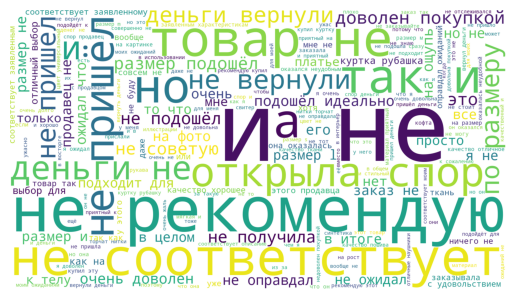

In [68]:
%%time

merged_text = reviews['review'].str.cat(sep=' ').lower()

wc = WordCloud(width=1920, height=1080, background_color="white").generate(merged_text)
plt.imshow(wc)
plt.axis("off");

CPU times: total: 4.52 s
Wall time: 10.3 s


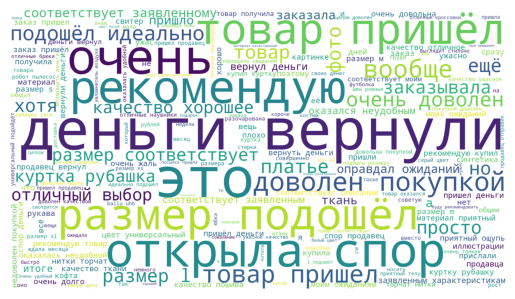

In [69]:
%%time

merged_text = reviews['review'].str.cat(sep=' ').lower()
stop_words = set(stopwords.words('russian'))
filtered_words = [word for word in merged_text.split() if word not in stop_words]
filtered_text = ' '.join(filtered_words)

wc = WordCloud(width=1920, height=1080, background_color="white").generate(filtered_text)
plt.imshow(wc)
plt.axis("off");

In [ ]:
%%time

merged_text = reviews['review'].str.cat(sep=' ').lower()
stop_words = set(stopwords.words('russian'))
stop_words.remove('не')
filtered_words = [word for word in merged_text.split() if word not in stop_words]
filtered_text = ' '.join(filtered_words)

wc = WordCloud(width=1920, height=1080, background_color="white").generate(filtered_text)
plt.imshow(wc)
plt.axis("off");

In [ ]:
from pymorphy3 import MorphAnalyzer

morph = MorphAnalyzer()
morph.parse('машина')[0].normal_form

### Text Cleaning

In [4]:
def clean_text(text):
    from razdel import tokenize
    from pymorphy3 import MorphAnalyzer
    from nltk.corpus import stopwords

    text = text.lower()

    sw_to_drop = ['не']
    
    morph = MorphAnalyzer()
    sws = set(stopwords.words('russian'))

    for sw in sw_to_drop:
        sws.remove(sw)
    
    tokens = tokenize(text)
    tokens = [morph.parse(token.text)[0].normal_form for token in tokens]
    tokens = [token for token in tokens if token not in sws]

    return ' '.join(tokens) 

In [5]:
reviews['processed_text'] = reviews['review'].parallel_apply(clean_text)

In [6]:
reviews

review  is_AI  \
0     Жаль, крем не оправдал ожиданий. Заявленный эф...      1   
1     Платье красивое, но мне пришло с браком, очень...      0   
2     Посылка пришла в непотребном виде.Получила на ...      0   
3     Маленький принц’, 12+, оказался совсем не мале...      1   
4     Адовая синтетика, но что за такую цену можно в...      0   
...                                                 ...    ...   
4685  Платье полностью не соответствует размеруXXL,к...      0   
4686  Качество хорошее, свитер пушистый. Но размер н...      0   
4687  Три месяца ждала заказ , так и не дождалась.\r...      0   
4688                   Заказ не пришёл. Деньги вернули       0   
4689  Отличные брюки. Тёмно-синий цвет подходит к мо...      1   

                                         processed_text  
0     жаль , крем не оправдать ожидание . заявить эф...  
1       платье красивый , прийти брак , очень неприятно  
2     посылка прийти непотребный вид . получить почт...  
3     маленький принц ’ , 12 + , оказаться не малень...  
4               адовый синтетик , цена впринцип ожидать  
...                                                 ...  
4685  платье полностью не соответствовать размер xxl...  
4686  качество хороший , свитер пушистый . размер не...  
4687  месяц ждать заказ , не дождаться . не рекоменд...  
4688                   заказ не прийти . деньга вернуть  
4689  отличный брюки . тёмно-синий цвет подходить ко...  

[23446 rows x 3 columns]

### Zipf Distribution

In [7]:
def plot_zipf_diagram(texts: pd.Series) -> None:
    from collections import Counter
    import matplotlib.pyplot as plt

    plt.figure(figsize=(20, 10))
    
    text = texts.str.cat(sep=' ')
    tokens = text.split()
    counts = Counter(tokens).most_common()
    labels = [label for label, count in counts]
    counts = [count for label, count in counts]
    plt.bar(counts, range(len(set(tokens))))
    plt.xlim(0, 250)


def compare_zipf_diagrams(texts_real: pd.Series, texts_generated: pd.Series):
    from collections import Counter
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 6))

    text = texts_generated.str.cat(sep=' ')
    tokens = text.split()
    counts = Counter(tokens).most_common()
    labels, values = [], []
    for label, value in counts:
        labels.append(label)
        values.append(value)
    plt.bar(range(len(set(tokens))), values, label='generated', alpha=0.5)
    
    text = texts_real.str.cat(sep=' ')
    tokens = text.split()
    counts = Counter(tokens).most_common()
    labels, values = [], []
    for label, value in counts:
        labels.append(label)
        values.append(value)
        
    plt.bar(range(len(set(tokens))), values, label='real', alpha=0.5)
    
    plt.xlim(0, 250)
    plt.title('Zipf Distribution')
    plt.xlabel('Some word index')
    plt.ylabel('Number of occurrencies')

    plt.grid()
    plt.legend()
    plt.tight_layout()

In [8]:
reviews.is_AI.value_counts()

is_AI
1    11723
0    11723
Name: count, dtype: int64

**Для оригинальных отзывов**

In [9]:
%%time

compare_zipf_diagrams(reviews.query('is_AI == 0')['review'], reviews.query('is_AI == 1')['review'])
plt.savefig(f'../../visualization/zip_diagrams_original.png', dpi=400)
plt.clf()

CPU times: total: 1min 6s
Wall time: 1min 7s


<Figure size 1200x600 with 0 Axes>

**Для предобработанных отзывов**

In [10]:
%%time

compare_zipf_diagrams(reviews.query('is_AI == 0')['processed_text'], reviews.query('is_AI == 1')['processed_text'])
plt.savefig(f'../../visualization/zip_diagrams_preprocessed.png', dpi=400)
plt.clf()

CPU times: total: 20.3 s
Wall time: 20.4 s


<Figure size 1200x600 with 0 Axes>

### Just words distribution

In [11]:
def get_words_number_of_occurrencies(texts: pd.Series) -> pd.DataFrame:
    from collections import Counter

    text = texts.str.cat(sep=' ')
    tokens = text.split()
    counts = Counter(tokens).most_common()
    df = pd.DataFrame(counts)
    return df



In [12]:
real = get_words_number_of_occurrencies(reviews.query('is_AI == 0')['processed_text'])
real.index = real[0]
real.drop(columns=[0], inplace=True)
generated = get_words_number_of_occurrencies(reviews.query('is_AI == 1')['processed_text'])
generated.index = generated[0]
generated.drop(columns=[0], inplace=True)

In [13]:
real

1
0                
,           25302
.           22761
не          17073
продавец     5016
деньга       4502
...           ...
трухан          1
малютка         1
зарекаться      1
грабли          1
polyester       1

[11328 rows x 1 columns]

In [14]:
generated

1
0                 
.            36950
,            19299
не            9956
размер        4926
купить        3681
...            ...
существенно      1
держатель        1
вечеринка        1
запрашивать      1
усидчивость      1

[5640 rows x 1 columns]

In [15]:
real, generated = real.align(generated, axis=0, fill_value=0.0)
stats = pd.concat([real, generated], axis=1)
stats.columns = ['real', 'generated']
stats

real  generated
0                         
!        4113.0     1369.0
!!        258.0        0.0
!!!      1121.0        0.0
!!!!      418.0        0.0
!!!!!     140.0        0.0
...         ...        ...
➕           1.0        0.0
⭐️⭐️        1.0        0.0
！           1.0        0.0
！деньга     1.0        0.0
（s）         1.0        0.0

[14049 rows x 2 columns]

In [26]:
plt.bar(range(len(stats)), (stats['real'] - stats['generated']).abs(), label='real')
plt.title('The absolute value of differencies for word occurrencies \n in Real and Generated reviews')
plt.xlabel('Some word ID in both Real and Generated datasets')
plt.ylabel('The difference in number of occurrencies')
plt.ylim(0, 200);

plt.savefig(f'../../visualization/Difference_in_word_occurrencies.png', dpi=400)
plt.clf()

<Figure size 640x480 with 0 Axes>

### TextStat

In [17]:
meth_ignore_list = ['set_lang',  # Not appropriate
                    'wiener_sachtextformel',
                     'avg_character_per_word',  'avg_syllables_per_word',  
                     'count_arabic_long_words',  'count_arabic_syllables',  
                    'count_complex_arabic_words', 'count_faseeh', 
                    'dale_chall_readability_score', 'dale_chall_readability_score_v2', 
                   'is_difficult_word', 'is_easy_word', 
                   'letter_count', 'osman', 
                   'polysyllabcount', 'rix', 'smog_index', 
                    'spache_readability', 'szigriszt_pazos'
                   ]
good_methods: dict[str, Callable] = {}

for meth_name in dir(textstat):
    # print(meth_name)
    if not meth_name.startswith('__') and meth_name not in meth_ignore_list:
        meth = getattr(textstat, meth_name)
        if isinstance(meth, Callable):
            try:
                res = meth(reviews['processed_text'].iloc[0])
                if isinstance(res, (int, float, bool)):
                    print(meth_name, res)   
                    good_methods[meth_name] = meth
            except Exception as e:
                print(e)
                raise e

def apply_textstat(text, meth): 
    try:
        res = meth(text)
    except OSError:
        return None
    except ZeroDivisionError:
        return None
    return res


# X_train = X.copy()
# y_train = y.copy()
# X_test = test.copy()

for meth_name, meth in tqdm(good_methods.items()):
    reviews[meth_name] = reviews['review'].progress_apply(apply_textstat, args=(meth,))
# for meth_name, meth in tqdm(good_methods.items()):
#     reviews[meth_name] = reviews['review'].progress_apply(apply_textstat, args=(meth,))

automated_readability_index 12.5
avg_letter_per_word 6.4
avg_sentence_length 3.8
avg_sentence_per_word 0.27
char_count 102
coleman_liau_index 13.33
crawford -4.1
difficult_words 0
fernandez_huerta 142.96
flesch_kincaid_grade -2.4
flesch_reading_ease 118.38
gulpease_index 101.0
gunning_fog 1.52
gutierrez_polini 31.81
lexicon_count 15
linsear_write_formula 1.625
lix 37.13
long_word_count 7
mcalpine_eflaw 4.5
miniword_count 3
monosyllabcount 15
reading_time 1.5
sentence_count 4
syllable_count 15
words_per_sentence 3.75


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/23446 [00:00<?, ?it/s]

  0%|          | 0/23446 [00:00<?, ?it/s]

  0%|          | 0/23446 [00:00<?, ?it/s]

  0%|          | 0/23446 [00:00<?, ?it/s]

  0%|          | 0/23446 [00:00<?, ?it/s]

  0%|          | 0/23446 [00:00<?, ?it/s]

  0%|          | 0/23446 [00:00<?, ?it/s]

  0%|          | 0/23446 [00:00<?, ?it/s]

  0%|          | 0/23446 [00:00<?, ?it/s]

  0%|          | 0/23446 [00:00<?, ?it/s]

  0%|          | 0/23446 [00:00<?, ?it/s]

  0%|          | 0/23446 [00:00<?, ?it/s]

  0%|          | 0/23446 [00:00<?, ?it/s]

  0%|          | 0/23446 [00:00<?, ?it/s]

  0%|          | 0/23446 [00:00<?, ?it/s]

  0%|          | 0/23446 [00:00<?, ?it/s]

  0%|          | 0/23446 [00:00<?, ?it/s]

  0%|          | 0/23446 [00:00<?, ?it/s]

  0%|          | 0/23446 [00:00<?, ?it/s]

  0%|          | 0/23446 [00:00<?, ?it/s]

  0%|          | 0/23446 [00:00<?, ?it/s]

  0%|          | 0/23446 [00:00<?, ?it/s]

  0%|          | 0/23446 [00:00<?, ?it/s]

  0%|          | 0/23446 [00:00<?, ?it/s]

  0%|          | 0/23446 [00:00<?, ?it/s]

In [18]:
reviews.head(3)

review  is_AI  \
0  Жаль, крем не оправдал ожиданий. Заявленный эф...      1   
1  Платье красивое, но мне пришло с браком, очень...      0   
2  Посылка пришла в непотребном виде.Получила на ...      0   

                                      processed_text  \
0  жаль , крем не оправдать ожидание . заявить эф...   
1    платье красивый , прийти брак , очень неприятно   
2  посылка прийти непотребный вид . получить почт...   

   automated_readability_index  avg_letter_per_word  avg_sentence_length  \
0                         11.5                 6.20                  3.8   
1                          8.2                 5.11                  9.0   
2                         13.1                 6.30                  6.7   

   avg_sentence_per_word  char_count  coleman_liau_index  crawford  ...  \
0                   0.27          99               12.17      -4.1  ...   
1                   0.11          48               10.58      -0.9  ...   
2                   0.15         265               16.30      -1.7  ...   

   linsear_write_formula    lix  long_word_count  mcalpine_eflaw  \
0               0.875000  50.47                7             4.5   
1               3.500000  42.33                2            12.0   
2               2.333333  54.20               19             8.3   

   miniword_count  monosyllabcount  reading_time  sentence_count  \
0               3               15          1.45               4   
1               3                9          0.71               1   
2              10               40          3.89               6   

   syllable_count  words_per_sentence  
0              15            3.750000  
1               9            9.000000  
2              40            6.666667  

[3 rows x 28 columns]

In [19]:
reviews.isna().any()

review                         False
is_AI                          False
processed_text                 False
automated_readability_index    False
avg_letter_per_word            False
avg_sentence_length            False
avg_sentence_per_word          False
char_count                     False
coleman_liau_index             False
crawford                       False
difficult_words                False
fernandez_huerta               False
flesch_kincaid_grade           False
flesch_reading_ease            False
gulpease_index                 False
gunning_fog                    False
gutierrez_polini               False
lexicon_count                  False
linsear_write_formula          False
lix                            False
long_word_count                False
mcalpine_eflaw                 False
miniword_count                 False
monosyllabcount                False
reading_time                   False
sentence_count                 False
syllable_count                 False
w

In [20]:
reviews.to_csv('./reviews_preprocessed_with_textstat.csv', index=False)

In [21]:
for col in tqdm(reviews.columns[3:]):
    plt.figure(figsize=(10, 6))
    for is_AI in (0, 1):
        cur_df = reviews.query('is_AI == @is_AI')
        plt.bar(range(len(cur_df)), cur_df[col], alpha=0.5, label='generated' if is_AI == 1 else 'real')

    plt.title(col)
    plt.xlabel('Each review')
    plt.ylabel('Values')
    plt.grid()
    plt.legend()
    plt.savefig(f'../../visualization/images_textstat_features_ordered/{col}.png', dpi=400)
    plt.clf()

  0%|          | 0/25 [00:00<?, ?it/s]

C:\Users\Yaroslav Pristalov\AppData\Local\Temp\ipykernel_11936\3120089230.py:12: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'../../visualization/images_textstat_features_ordered/{col}.png', dpi=400)
C:\Users\Yaroslav Pristalov\AppData\Local\Temp\ipykernel_11936\3120089230.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [22]:
for col in tqdm(reviews.columns[3:]):
    plt.figure(figsize=(10, 6))
    for is_AI in (0, 1):
        cur_df = reviews.query('is_AI == @is_AI')
        cur_df.sort_values(col, ascending=False, inplace=True)
        plt.bar(range(len(cur_df)), cur_df[col], alpha=0.5, label='generated' if is_AI == 1 else 'real')

    plt.title(col)
    plt.xlabel('Some reviews')
    plt.ylabel('Values')
    plt.grid()
    plt.legend()    
    plt.savefig(f'../../visualization/images_textstat_features_sorted_hist/{col}.png', dpi=400)
    plt.clf()

  0%|          | 0/25 [00:00<?, ?it/s]

C:\Users\Yaroslav Pristalov\AppData\Local\Temp\ipykernel_11936\2592155008.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_df.sort_values(col, ascending=False, inplace=True)
C:\Users\Yaroslav Pristalov\AppData\Local\Temp\ipykernel_11936\2592155008.py:13: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'../../visualization/images_textstat_features_sorted_hist/{col}.png', dpi=400)
C:\Users\Yaroslav Pristalov\AppData\Local\Temp\ipykernel_11936\2592155008.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplot

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

### `ydata_profiling`

In [34]:
# !pip install ydata_profiling

In [23]:
from ydata_profiling import ProfileReport

profile = ProfileReport(reviews.iloc[:, :3], title="Profiling Report")

In [24]:
with open('ydata_profiling.html', 'wt', encoding='UTF-8') as f:
    f.write(profile.to_html())

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

D:\ProgramData\anaconda3\envs\kaggle\lib\site-packages\ydata_profiling\model\typeset.py:125: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  not pdt.is_categorical_dtype(series)
D:\ProgramData\anaconda3\envs\kaggle\lib\site-packages\ydata_profiling\model\typeset.py:208: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_valid_dtype = pdt.is_categorical_dtype(series) and not pdt.is_bool_dtype(
D:\ProgramData\anaconda3\envs\kaggle\lib\site-packages\ydata_profiling\model\typeset.py:125: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  not pdt.is_categorical_dtype(series)
D:\ProgramData\anaconda3\envs\kaggle\lib\site-packages\ydata_profiling\model\typeset_relations.py:34: FutureWarning: is_categorical_dtype is deprec

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [25]:
reviews

review  is_AI  \
0     Жаль, крем не оправдал ожиданий. Заявленный эф...      1   
1     Платье красивое, но мне пришло с браком, очень...      0   
2     Посылка пришла в непотребном виде.Получила на ...      0   
3     Маленький принц’, 12+, оказался совсем не мале...      1   
4     Адовая синтетика, но что за такую цену можно в...      0   
...                                                 ...    ...   
4685  Платье полностью не соответствует размеруXXL,к...      0   
4686  Качество хорошее, свитер пушистый. Но размер н...      0   
4687  Три месяца ждала заказ , так и не дождалась.\r...      0   
4688                   Заказ не пришёл. Деньги вернули       0   
4689  Отличные брюки. Тёмно-синий цвет подходит к мо...      1   

                                         processed_text  \
0     жаль , крем не оправдать ожидание . заявить эф...   
1       платье красивый , прийти брак , очень неприятно   
2     посылка прийти непотребный вид . получить почт...   
3     маленький принц ’ , 12 + , оказаться не малень...   
4               адовый синтетик , цена впринцип ожидать   
...                                                 ...   
4685  платье полностью не соответствовать размер xxl...   
4686  качество хороший , свитер пушистый . размер не...   
4687  месяц ждать заказ , не дождаться . не рекоменд...   
4688                   заказ не прийти . деньга вернуть   
4689  отличный брюки . тёмно-синий цвет подходить ко...   

      automated_readability_index  avg_letter_per_word  avg_sentence_length  \
0                            11.5                 6.20                  3.8   
1                             8.2                 5.11                  9.0   
2                            13.1                 6.30                  6.7   
3                             7.5                 5.17                  5.8   
4                             7.2                 4.82                 11.0   
...                           ...                  ...                  ...   
4685                          9.4                 5.42                  8.7   
4686                          9.6                 5.66                  5.8   
4687                          6.6                 4.60                 10.0   
4688                          6.5                 5.20                  5.0   
4689                          6.7                 5.00                  6.8   

      avg_sentence_per_word  char_count  coleman_liau_index  crawford  ...  \
0                      0.27          99               12.17      -4.1  ...   
1                      0.11          48               10.58      -0.9  ...   
2                      0.15         265               16.30      -1.7  ...   
3                      0.17         160                9.15      -2.1  ...   
4                      0.09          54                9.49      -0.5  ...   
...                     ...         ...                 ...       ...  ...   
4685                   0.12         146               12.08      -1.0  ...   
4686                   0.17         173               12.00      -2.1  ...   
4687                   0.10          49                7.92      -0.7  ...   
4688                   0.20          27                8.44      -2.7  ...   
4689                   0.15         142                8.76      -1.6  ...   

      linsear_write_formula    lix  long_word_count  mcalpine_eflaw  \
0                  0.875000  50.47                7             4.5   
1                  3.500000  42.33                2            12.0   
2                  2.333333  54.20               19             8.3   
3                  1.900000  47.18               10             8.0   
4                  4.500000  38.27                3            15.0   
...                     ...    ...              ...             ...   
4685               3.333333  31.78                6            12.0   
4686               2.000000  42.47               11             8.0   
4687               4.5

---

In [48]:
print(reviews.shape)
print(reviews.drop_duplicates('review').shape)

(29288, 28)
(26367, 28)


In [53]:
reviews.drop_duplicates('review')[['review', 'is_AI']].to_csv('unique_reviews.csv', index=False)

In [55]:
new_reviews = pd.read_csv('./unique_reviews.csv')
new_reviews

review  is_AI
0      Продавец выслал не тот цвет, я очень расстроил...      0
1      Отличные часы! Купил их для подруги. Качество ...      1
2                                   редкостная дрянь....      0
3      Купил отцу этот фильтр, он доволен. Но я счита...      1
4      Купил подгузники Huggies Elite Soft для моей с...      1
...                                                  ...    ...
26362  Отличная зубная паста. Хорошо пенится. Вкус и ...      1
26363  Купил витамины для волос после рекомендации тр...      1
26364              Коллега будет доволен. Вещь хорошая\n      1
26365  ужасные шорты. в реальности сильно отличаются ...      0
26366  Ужасный продавец. Ни товара, ни денег!!! Прожд...      0

[26367 rows x 2 columns]

In [67]:
new_reviews.is_AI.value_counts()

is_AI
0    14644
1    11723
Name: count, dtype: int64

In [72]:
new_reviews = pd.concat([new_reviews.query('is_AI == 0').sample(11723), new_reviews.query('is_AI == 1')], axis=0).reset_index(drop=True)
new_reviews

review  is_AI
0      Здравствуйте! Качество куртки плохое, сама кур...      0
1      Штаны приятные к телу,но не такие как на фото,...      0
2      очень плохое качество товара, швы не ровные, з...      0
3      Заказывал размер  XL. но товар не соответствуе...      0
4      продавец отправил на на тот адрес, ходя я неод...      0
...                                                  ...    ...
23441  Я купил беспроводные наушники Xiaomi Redmi Bud...      1
23442  Пылесос пришёл в помятой коробке. Это говорит ...      1
23443  Отличная зубная паста. Хорошо пенится. Вкус и ...      1
23444  Купил витамины для волос после рекомендации тр...      1
23445              Коллега будет доволен. Вещь хорошая\n      1

[23446 rows x 2 columns]

In [76]:
new_reviews.is_AI.value_counts()

is_AI
0    11723
1    11723
Name: count, dtype: int64

In [79]:
train, test = train_test_split(new_reviews, test_size=0.2, random_state=42)

In [80]:
train.is_AI.value_counts()

is_AI
1    9391
0    9365
Name: count, dtype: int64

In [81]:
test.is_AI.value_counts()

is_AI
0    2358
1    2332
Name: count, dtype: int64

In [85]:
train.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)

In [86]:
train.to_csv('train_unique_reviews.csv', index=False)
test.to_csv('test_unique_reviews.csv', index=False)

In [89]:
pd.read_csv('test_unique_reviews.csv')

review  is_AI
0            Цвет не тот. Не тянется. Ужасное качество       0
1     Мне не понравился этот гольф, хоть он и мягок ...      0
2     пришел с браком- дырка большая на спинке. День...      0
3     Не подошли по размеру. Размер L оказался мне м...      1
4     Книга отличная, но не для детей 10+, а для дош...      1
...                                                 ...    ...
4685  Платье полностью не соответствует размеруXXL,к...      0
4686  Качество хорошее, свитер пушистый. Но размер н...      0
4687  Три месяца ждала заказ , так и не дождалась.\r...      0
4688                   Заказ не пришёл. Деньги вернули       0
4689  Отличные брюки. Тёмно-синий цвет подходит к мо...      1

[4690 rows x 2 columns]